###### Multi-Layer Perceptron, MNIST
Steps to train an MLP(Multi-Layer Perceptron) to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

In [1]:
#import libraries
import torch
import numpy as np

###### Load and Visualize the

In [2]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
#Define number of subprocess to use for data loading
num_workers=0
#Define samples per batch to load
batch_size=20
#Define percentage of training set to use as validation
valid_size=0.2
#Convert data to torch.FloatTensor
transform=transforms.ToTensor()
#Download training data
trainset=datasets.MNIST(root='data',download=True,train=True,transform=transform)
#Download test data
testset=datasets.MNIST(root='data',download=True,train=True,transform=transform)
#Obtain training indices that will be used for validation
num_train=len(trainset)
indices=list(range(num_train))
np.random.shuffle(indices)
split=int(np.floor(valid_size*num_train))
train_idx,valid_idx=indices[split:],indices[:split]
#Define samplers for obtaining training and validation batches
train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)
#Load training data
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,num_workers=num_workers,sampler=train_sampler)
#Load validation data
validloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,num_workers=num_workers,sampler=valid_sampler)
#Load test data
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,num_workers=num_workers)

###### Visualize a Batch of Training Data

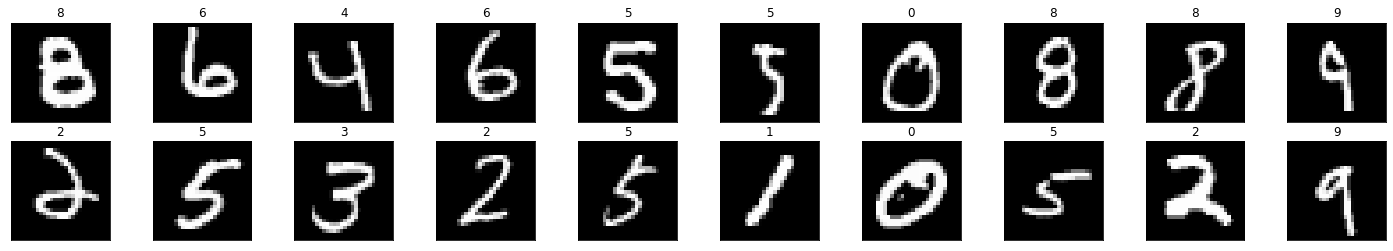

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
#To see one batch of training images
dataiter=iter(trainloader)
images,labels=dataiter.next()
images=images.numpy()
#To show images in the batch,with corresponding labels
fig=plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[idx]),cmap='gray')
    #To print the correct label for each image
    #.item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

###### View an Image in More Detail

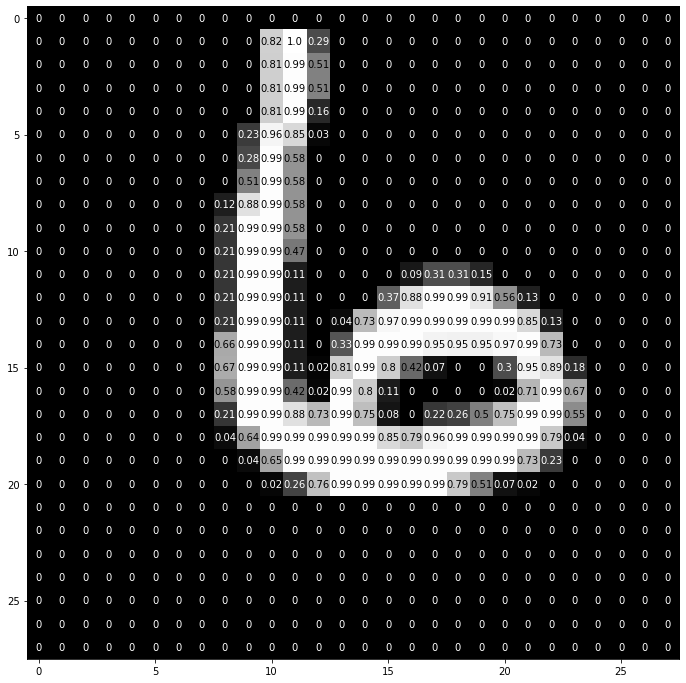

In [4]:
img=np.squeeze(images[1])
fig=plt.figure(figsize=(12,12)) 
ax=fig.add_subplot(111)
ax.imshow(img,cmap='gray')
width,height=img.shape
thresh=img.max()/2.5
for x in range(width):
    for y in range(height):
        val=round(img[x][y],2)if img[x][y] !=0 else 0
        ax.annotate(str(val),xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

###### Define the Network Architecture
The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [5]:
import torch.nn as nn
import torch.nn.functional as F
#Define network architecture
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        #Define hidden layer
        hidden1=512
        hidden2=512
        #linear layer (784(input layer)->1 hidden node)
        self.fc1=nn.Linear(28 * 28, hidden1)
        #linear layer (1 hidden node->2 hidden node)
        self.fc2=nn.Linear(hidden1,hidden2)
        #linear layer(2hidden node->10(output layer))
        self.fc3=nn.Linear(hidden2,10)
        #Define dropout to prevents overfitting
        self.dropout=nn.Dropout(0.02)
    def forward(self, x):
        #flatten image input
        x=x.view(-1,28 * 28)
        #Add hidden layer using relu activation function
        x=F.relu(self.fc1(x))
        #Add dropout layer
        x=F.dropout(x)
        #Add hidden layer using relu activation function
        x=F.relu(self.fc2(x))
        #Add dropout layer
        x=F.dropout(x)
        #Add output layer
        x=self.fc3(x)
        return x
#Initialize the Network
model=Network()
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.02, inplace=False)
)


###### Specify Loss Function and Optimizer

In [6]:
#specify loss function
criterion=nn.CrossEntropyLoss()
#specify optimizer
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

###### Train the Network:
Steps for training/learning from a batch of data:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

In [7]:
#Define number of epochs to train the model
num_epochs=50
#Initialize tracker for minimum validation loss
#Set initial "min" to infinity
valid_loss_min=np.Inf 
for epoch in range(num_epochs):
    #Monitor training loss
    train_loss=0.0 
    valid_loss=0.0
    #Define model for training
    model.train()
    #Train the model
    for data,target in trainloader:
        #1.Clear the gradients of all optimized variables
        optimizer.zero_grad()
        #2.Forward pass:compute predicted outputs by passing inputs to the model
        output=model(data)
        #3.Calculate the loss
        loss=criterion(output,target)
        #4.Backward pass:compute gradient of the loss with respect to model parameters
        loss.backward()
        #5.Perform a single optimization step (parameter update)
        optimizer.step()
        #6.Update running training loss
        train_loss+=loss.item()*data.size(0) 
    #Validate the model 
    #Define model for evaluation
    model.eval() 
    for data,target in validloader:
        #1.forward pass: compute predicted outputs by passing inputs to the model
        output=model(data)
        #2.calculate the loss
        loss=criterion(output,target)
        #3.update running validation loss 
        valid_loss+=loss.item()*data.size(0)
        
    #To Print training & validation statistics 
    #Calculate average loss over an epoch
    train_loss=train_loss/len(trainloader.sampler)
    #Calculate average loss over an epoch
    valid_loss=train_loss/len(validloader.sampler)
    print('Epoch: {} \tTraining Loss: {:.6f}\tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    #Save model if validation loss has decreased
    if valid_loss<=valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(),'model.pt')
        valid_loss_min=valid_loss

Epoch: 1 	Training Loss: 1.059963	Validation Loss: 0.000088
Validation loss decreased (inf --> 0.000088).  Saving model ...
Epoch: 2 	Training Loss: 0.418039	Validation Loss: 0.000035
Validation loss decreased (0.000088 --> 0.000035).  Saving model ...
Epoch: 3 	Training Loss: 0.323763	Validation Loss: 0.000027
Validation loss decreased (0.000035 --> 0.000027).  Saving model ...
Epoch: 4 	Training Loss: 0.272614	Validation Loss: 0.000023
Validation loss decreased (0.000027 --> 0.000023).  Saving model ...
Epoch: 5 	Training Loss: 0.232313	Validation Loss: 0.000019
Validation loss decreased (0.000023 --> 0.000019).  Saving model ...
Epoch: 6 	Training Loss: 0.206893	Validation Loss: 0.000017
Validation loss decreased (0.000019 --> 0.000017).  Saving model ...
Epoch: 7 	Training Loss: 0.183804	Validation Loss: 0.000015
Validation loss decreased (0.000017 --> 0.000015).  Saving model ...
Epoch: 8 	Training Loss: 0.168657	Validation Loss: 0.000014
Validation loss decreased (0.000015 --> 0.

######  Load the Model with the Lowest Validation Loss

In [8]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

###### Test the Trained Network

In [10]:
#Define lists to monitor test loss and accuracy
test_loss=0.0
class_correct=list(0. for i in range(10))
class_total=list(0. for i in range(10))
#Define model for evaluation
model.eval()
for data,target in testloader:
    #1.Forward pass:testloadercompute predicted outputs by passing inputs to the model
    output=model(data)
    #2.Calculate the loss
    loss=criterion(output,target)
    #3.Update test loss 
    test_loss+=loss.item()*data.size(0)
    #4.Convert output probabilities to predicted class
    _, pred=torch.max(output,1)
    #5.Compare predictions to true label
    correct=np.squeeze(pred.eq(target.data.view_as(pred)))
    #6.Calculate test accuracy for each object class
    for i in range(len(target)):
        label=target.data[i]
        class_correct[label]+=correct[i].item()
        class_total[label]+=1
# calculate and print avg test loss
test_loss=test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%(
            str(i),100*class_correct[i]/class_total[i],
            np.sum(class_correct[i]),np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)'%(classes[i]))
        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)'%(
    100.*np.sum(class_correct)/np.sum(class_total),
    np.sum(class_correct),np.sum(class_total)))

Test Loss: 0.046376

Test Accuracy of     0: 99% (5895/5923)
Test Accuracy of     1: 99% (6698/6742)
Test Accuracy of     2: 98% (5875/5958)
Test Accuracy of     3: 97% (6003/6131)
Test Accuracy of     4: 98% (5777/5842)
Test Accuracy of     5: 98% (5314/5421)
Test Accuracy of     6: 99% (5870/5918)
Test Accuracy of     7: 98% (6175/6265)
Test Accuracy of     8: 97% (5716/5851)
Test Accuracy of     9: 97% (5818/5949)

Test Accuracy (Overall): 98% (59141/60000)


###### Visualize Sample Test Results

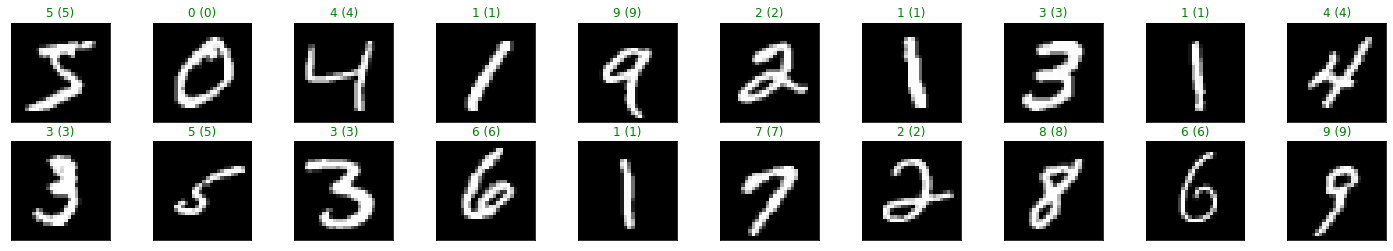

In [11]:
#To see one batch of test images
dataiter=iter(testloader)
images,labels=dataiter.next()
#sample outputs
output=model(images)
#Convert output probabilities to predicted class
_, preds=torch.max(output,1)
#prepare images for display
images=images.numpy()
#To show images in the batch with predicted and true labels
fig=plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[idx]),cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()),str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))